In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib
import re as re
import sqlite3

In [2]:
def read_all_tables(connection):
    files_dict = {}
    db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", connection)
    for table in db_tables['name']:
        files_dict[table] = read_table(table, connection)
    return files_dict
def read_table(table_name, connection):
     return pd.read_sql_query("SELECT * from {}".format(table_name), connection)
    
conn = sqlite3.connect('datascience-stackexchange.db')
files_df = read_all_tables(conn)

In [3]:
def split_impl(df):
    x = df['Text'].str.findall(r'\<.*?\>')
    return (x)

files_df['PostHistory'].head()
post_history = files_df['PostHistory'].copy()
post_history.drop(post_history.loc[post_history['PostHistoryTypeId'] != 3].index, inplace=True)
post_history.drop(post_history.loc[post_history['UserId'] == ''].index, inplace=True)
post_history = post_history.dropna(subset=['Text', 'UserId'])
post_history['UserId'] = post_history['UserId'].astype('int64')
post_history['Text'] = split_impl(post_history)

In [4]:
tag_count = post_history['UserId'].value_counts().to_frame()
tag_count = tag_count.rename(columns={'UserId':'Post with Tag Count'})
tag_count['UserId'] = tag_count.index
tag_count = tag_count.reset_index(drop=True)
tag_count_top_100_user = tag_count[:100]
tag_count_top_100_user

,Post with Tag Count,UserId
0,102,8820
1,71,64876
2,66,43077
3,60,84229
4,53,21560
...,...,...
95,16,41557
96,16,83275
97,16,37986
98,16,8432


In [5]:
percentage_top_5_df = pd.DataFrame(columns=['Percentage', 'UserId'])
tag_count_user = post_history.copy()

c = 0
for user in tag_count_top_100_user['UserId']:
    tag_count_user = post_history.copy()
    total_tag_count = tag_count_top_100_user.loc[tag_count_top_100_user['UserId']== user]['Post with Tag Count'][c]
    c += 1
    tag_count_user.drop(tag_count_user.loc[tag_count_user['UserId'] != user].index, inplace=True)
    tag_count_user.drop(tag_count_user.loc[tag_count_user['PostHistoryTypeId'] != 3].index, inplace=True)
    z = tag_count_user.Text
    new_obj = {}
    for i in z:
        for j in i:
            j = j.replace('<', '')
            j = j.replace('>', '')
            if j not in new_obj.keys():
                new_obj[j] = 1
            else:
                new_obj[j] += 1
    new_obj = dict(sorted(new_obj.items(), key=lambda item: item[1], reverse = True))
    user_df = pd.DataFrame.from_dict(new_obj, orient='index')[:5]
    user_df['Percentage'] = user_df[0]/total_tag_count
    user_df = user_df.reset_index(drop=True)
    user_df = user_df[['Percentage']]
    user_df['UserId'] = user
    percentage_top_5_df = pd.concat([percentage_top_5_df, user_df], ignore_index=True)
    
percentage_top_5_df

,Percentage,UserId
0,0.274510,8820
1,0.215686,8820
2,0.166667,8820
3,0.078431,8820
4,0.078431,8820
...,...,...
495,0.625000,98535
496,0.562500,98535
497,0.437500,98535
498,0.250000,98535


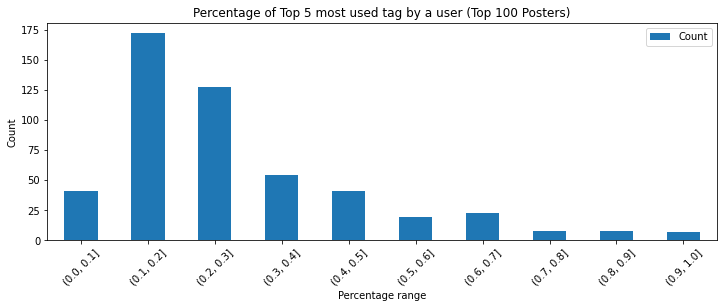

,Count
Percentage,
"(0.0, 0.1]",41
"(0.1, 0.2]",172
"(0.2, 0.3]",127
"(0.3, 0.4]",54
"(0.4, 0.5]",41
"(0.5, 0.6]",19
"(0.6, 0.7]",23
"(0.7, 0.8]",8
"(0.8, 0.9]",8


In [6]:
bins = pd.cut(percentage_top_5_df['Percentage'], np.arange(0,1.01, 0.1))
percentage_top_5_df_grouped = percentage_top_5_df.groupby(bins)['Percentage'].agg(['count']).rename(columns={'count':'Count'})

percentage_top_5_df_grouped.plot(kind="bar", figsize = (12,4))
plt.xlabel("Percentage range")
plt.ylabel("Count")
plt.title("Percentage of Top 5 most used tag by a user (Top 100 Posters)")
plt.xticks(rotation=45)
plt.savefig('plots/percentage-tag-user.png', dpi=150, pad_inches = 0.3, bbox_inches='tight')
plt.show()


percentage_top_5_df.describe()
percentage_top_5_df_grouped

In [7]:
len(percentage_top_5_df.loc[percentage_top_5_df['Percentage']>0.5]['UserId'].unique())

43

In [8]:
percentage_top_5_df.describe()

,Percentage
count,500.000000
mean,0.287897
std,0.192993
min,0.050000
25%,0.153846
50%,0.226540
75%,0.380952
max,1.000000


A user does not post on the same topic. Based on the top 100 users who posts, their top 5 mostly used tags in their posts only has a mean of 28.79%. Out of the top people who posts, there are just 43 out of 100 people who are posting on the same topic more than 50% of the time.